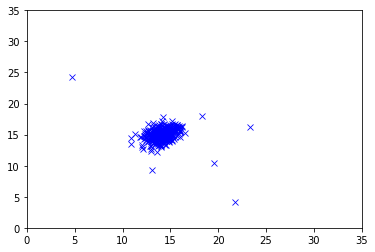

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab

df = pd.read_csv('data_train.csv')
pylab.ylim([0, 35])
pylab.xlim([0, 35])
plt.scatter(df["Latency"], df["Throughput"], marker="x", color="b", linewidths=0.8)

In [28]:
def estimateGaussian(df):
    [m, n] = df.shape
    mu = np.zeros([n, 1])
    mu = np.transpose(((1/m)*np.sum(df)))
    sigmasq = np.transpose(((1/m)*np.sum(np.power((df-np.transpose(mu)), 2))))
    return [mu, sigmasq]

[mu, sigmasq] = estimateGaussian(df)
print([mu, sigmasq])

[Latency       14.112225
Throughput    14.997712
dtype: float64, Latency       1.832633
Throughput    1.709742
dtype: float64]


In [29]:
from scipy.stats import multivariate_normal

def multivariateGaussian(df, mu, sigmasq):
    p = multivariate_normal.pdf(df, mean=mu, cov=sigmasq)
    return p

p = multivariateGaussian(df, mu, sigmasq)

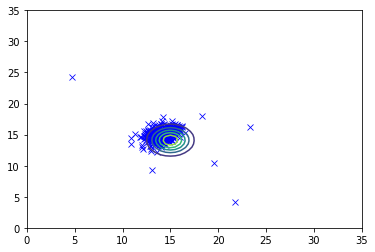

In [30]:
from scipy import stats
import itertools

def visualizeFit(df, mu, sigmasq):
    t = np.arange(0, 35.5, 0.5)
    h = np.arange(0, 35.5, 0.5)
    
    x1, x2 = np.meshgrid(t, h)
    x12 = [x for x in itertools.product(t, h)]
    df1 = pd.DataFrame(data=x12)

    z = multivariateGaussian(df1, mu, sigmasq)
    z = np.reshape(z, x1.shape)

    pylab.xlim([0, 35])
    pylab.ylim([0, 35])
    plt.scatter(df["Latency"], df["Throughput"], marker="x", color="b", linewidths=0.8)
    if np.sum(np.isinf(z)) == 0:
        plt.contour(x1, x2, z)#, np.exp(np.arange(-20, 0, 3), 10))
    
    return [x1, x2, z]
    
[x1, x2, z] = visualizeFit(df, mu, sigmasq)

In [59]:
def selectThreshold(y_val, pval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    itr = 0

    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        val_predicts = 1*(pval < epsilon)
        itr = itr + 1
        # tp = np.sum(((val_predicts == 1) & (y_val == 1)))
        # fp = np.sum(((val_predicts == 1) & (y_val == 0)))
        # fn = np.sum(((val_predicts == 0) & (y_val == 1)))
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(val_predicts)):
            if ((val_predicts[i] == 1) & (y_val[i] == 1)):
                tp = tp + 1
            elif ((val_predicts[i] == 1) & (y_val[i] == 0)):
                fp = fp + 1
            elif ((val_predicts[i] == 0) & (y_val[i] == 1)):
                fn = fn + 1

        if (tp == 0 & fp == 0): 
            prec = np.nan
        else:
            prec = tp/(tp+fp)
        if (tp == 0 & fn == 0):
            rec = np.nan
        else:
            rec = tp/(tp+fn)
        if (np.isnan(prec) | np.isnan(rec)):
            f1 = np.nan
        else:
            f1 = 2*prec*rec / (prec + rec)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon

        print(f"#{itr}  tp = {tp}  fp = {fp}  fn = {fn}  ep = {epsilon}")

    return best_epsilon, best_f1

In [60]:
data_val = pd.read_csv('data_val.csv')
df_val = data_val[['Latency', 'Throughput']]
y_val = data_val[['Yval']]

pval = multivariateGaussian(df_val, mu, sigmasq)
y_val = y_val["Yval"].to_numpy()
epsilon, F1 = selectThreshold(y_val, pval)

print(f"optimum epsilon: {epsilon}")
print(f"best F1 score: {F1}")

#1  tp = 0  fp = 0  fn = 9  ep = 4.5115422807551e-36
#2  tp = 7  fp = 0  fn = 2  ep = 8.990856744653516e-05
#3  tp = 7  fp = 0  fn = 2  ep = 0.00017981713489307032
#4  tp = 7  fp = 0  fn = 2  ep = 0.0002697257023396055
#5  tp = 7  fp = 0  fn = 2  ep = 0.00035963426978614065
#6  tp = 7  fp = 0  fn = 2  ep = 0.0004495428372326758
#7  tp = 7  fp = 1  fn = 2  ep = 0.000539451404679211
#8  tp = 7  fp = 1  fn = 2  ep = 0.0006293599721257461
#9  tp = 7  fp = 1  fn = 2  ep = 0.0007192685395722813
#10  tp = 7  fp = 1  fn = 2  ep = 0.0008091771070188165
#11  tp = 7  fp = 1  fn = 2  ep = 0.0008990856744653516
#12  tp = 7  fp = 1  fn = 2  ep = 0.0009889942419118868
#13  tp = 7  fp = 1  fn = 2  ep = 0.001078902809358422
#14  tp = 7  fp = 1  fn = 2  ep = 0.001168811376804957
#15  tp = 7  fp = 1  fn = 2  ep = 0.0012587199442514923
#16  tp = 7  fp = 1  fn = 2  ep = 0.0013486285116980274
#17  tp = 7  fp = 1  fn = 2  ep = 0.0014385370791445626
#18  tp = 7  fp = 1  fn = 2  ep = 0.0015284456465910977
#19 

outliers = 
     Latency  Throughput
300  13.0793      9.3479
301  21.7271      4.1262
303  19.5826     10.4116
304  23.3399     16.2989
305  18.2612     17.9783
306   4.7526     24.3504


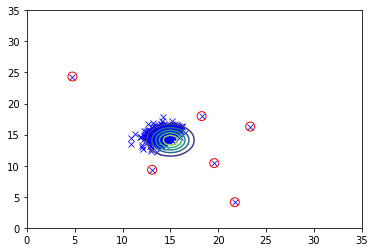

In [33]:
anomalies = np.asarray(np.where(p < epsilon)).flatten()
outliers = [df.iloc[x] for x in anomalies]
outliersdf = pd.DataFrame(data=outliers)
print(f"outliers = \n{outliersdf}")

pylab.xlim([0, 35])
pylab.ylim([0, 35])
plt.scatter(df["Latency"], df["Throughput"], marker="x", color="b", linewidths=0.8)
if np.sum(np.isinf(z)) == 0:
    plt.contour(x1, x2, z)#, np.exp(np.arange(-20, 0, 3), 10))
plt.scatter(outliersdf["Latency"], outliersdf["Throughput"], marker="o", s=80, facecolors='none', edgecolors="r")

In [34]:
#dataset 2
df_2 = pd.read_csv('data2_X.csv', header=None)
print(df_2.shape)

(1000, 11)


In [35]:
[mu2, sigmasq2] = estimateGaussian(df_2)
print([mu2, sigmasq2])

[0      4.939400
1     -9.637268
2     13.814707
3    -10.464489
4     -7.956229
5     10.199504
6     -6.019408
7      7.969829
8     -6.253182
9      2.324513
10     8.473723
dtype: float64, 0     60.974894
1     53.205722
2     58.515463
3     84.204037
4     65.268592
5     89.574878
6     55.633499
7     87.162338
8     29.629268
9     70.785205
10    50.503567
dtype: float64]


In [36]:
p2 = multivariateGaussian(df_2, mu2, sigmasq2)

In [62]:
data2_Xval = pd.read_csv('data2_Xval.csv', header=None)
data2_yval = pd.read_csv('data2_yval.csv', header=None)

pval2 = multivariateGaussian(data2_Xval, mu2, sigmasq2)
data2_yval = data2_yval.to_numpy()
epsilon_new, F1_new = selectThreshold(data2_yval, pval2)

print(f"optimum epsilon: {epsilon_new}")
print(f"best F1 score: {F1_new}")

#1  tp = 0  fp = 0  fn = 10  ep = 5.953349076111373e-26
#2  tp = 8  fp = 8  fn = 2  ep = 1.3772288907613604e-18
#3  tp = 9  fp = 13  fn = 1  ep = 2.7544577219892303e-18
#4  tp = 9  fp = 14  fn = 1  ep = 4.1316865532170996e-18
#5  tp = 9  fp = 17  fn = 1  ep = 5.508915384444969e-18
#6  tp = 9  fp = 19  fn = 1  ep = 6.886144215672839e-18
#7  tp = 9  fp = 20  fn = 1  ep = 8.26337304690071e-18
#8  tp = 9  fp = 22  fn = 1  ep = 9.640601878128578e-18
#9  tp = 9  fp = 22  fn = 1  ep = 1.1017830709356449e-17
#10  tp = 9  fp = 23  fn = 1  ep = 1.2395059540584319e-17
#11  tp = 9  fp = 24  fn = 1  ep = 1.3772288371812188e-17
#12  tp = 9  fp = 27  fn = 1  ep = 1.5149517203040055e-17
#13  tp = 10  fp = 27  fn = 0  ep = 1.6526746034267926e-17
#14  tp = 10  fp = 30  fn = 0  ep = 1.7903974865495796e-17
#15  tp = 10  fp = 30  fn = 0  ep = 1.9281203696723664e-17
#16  tp = 10  fp = 31  fn = 0  ep = 2.0658432527951534e-17
#17  tp = 10  fp = 31  fn = 0  ep = 2.2035661359179405e-17
#18  tp = 10  fp = 31  fn

In [63]:
anomalies2 = np.asarray(np.where(p2 < epsilon_new)).flatten()
outliers_new = [df_2.iloc[x] for x in anomalies2]
outliersdf2 = pd.DataFrame(data=outliers_new)
print(f"outliers_new = \n{outliersdf2}")

outliers_new = 
            0          1          2          3          4          5   \
9    15.107877 -16.430766  19.707360 -19.811888  -1.644537  -6.444184   
20   12.411706   3.150959  14.827734 -10.482672  -8.250082  -7.982698   
21   20.946754   1.048170   8.296324  -2.595042 -14.061970   8.776611   
30    5.127033 -18.517137  11.422480 -28.993408  -5.797960 -15.989215   
39   11.622006  -0.229723  10.005823  -9.700729 -14.765493  26.933578   
..         ...        ...        ...        ...        ...        ...   
952  -7.514689 -11.633082  12.714199  -9.659930 -20.170026  46.574569   
970   8.610956  -2.087595  13.609762  -5.509457   4.565548  -2.150133   
975   4.712890  -5.468014   7.463785  15.156009  -4.815854 -10.092629   
992 -12.120077  -5.845913  28.951978 -10.215184 -18.070297  15.439734   
996   3.059507  -5.926298  31.837423   0.245340  10.050776  -1.997428   

            6          7          8          9          10  
9    -6.121214   7.042283   7.232476  17.22347